In [85]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split
from gpytorch.kernels import Kernel
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
X_df=None
X_domain_info=None
y_df=None
with open('X_df.pkl', 'rb') as f:
    X_df = pickle.load(f)
with open('X_domain_info.pkl', 'rb') as f:
    X_domain_info = pickle.load(f)
with open('y_df.pkl', 'rb') as f:
    y_df = pickle.load(f)



num_conc=y_df.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.1, random_state=42)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

In [87]:

mask_bool_met = X_df.columns.str.contains("met")
mask_bool_mut = X_df.columns.str.contains("mut")
mask_bool_cna = X_df.columns.str.contains("cna")
mask_bool_dc  = X_df.columns.str.contains("dc")

mask_float_met = np.array(mask_bool_met, dtype=np.float32) 
mask_float_mut = np.array(mask_bool_mut, dtype=np.float32)
mask_float_cna = np.array(mask_bool_cna, dtype=np.float32)
mask_float_dc  = np.array(mask_bool_dc, dtype=np.float32)

diag_matrix_met = torch.tensor(np.diag(mask_float_met))
diag_matrix_mut = torch.tensor(np.diag(mask_float_mut))
diag_matrix_cna = torch.tensor(np.diag(mask_float_cna))
diag_matrix_dc  = torch.tensor(np.diag(mask_float_dc))
filters=(diag_matrix_mut,diag_matrix_met,diag_matrix_cna,diag_matrix_dc)

In [88]:
class HomemadeRBF(Kernel):
#TODO embed the domain information
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # Define a hyperparameter called 'scale'
        self.homemade_lengthscale = torch.nn.Parameter(torch.tensor(1.0))
        
        # Register the hyperparameter
        self.register_parameter(name='homemade_lengthscale', parameter=self.homemade_lengthscale)
    def forward(self, x1, x2,**params):

        variance_matrix = torch.var(x1-x2,dim=2)
        print(variance_matrix)

        return torch.exp(-variance_matrix/(2*(self.homemade_lengthscale**2)))
            

In [89]:
class QuadripleDRPKernel(Kernel):
    def __init__(self,filters, **kwargs):
        super().__init__(**kwargs)
        # Use a base kernel, e.g., RBFKernel
        # self.kernel_mu = HomemadeRBF()
        # self.kernel_met = HomemadeRBF()
        # self.kernel_cn = HomemadeRBF()
        # self.kernel_dc = HomemadeRBF()
        self.kernel_mu = gpytorch.kernels.RBFKernel()
        self.kernel_met = gpytorch.kernels.RBFKernel()
        self.kernel_cn = gpytorch.kernels.RBFKernel()
        # self.kernel_dc = gpytorch.kernels.RBFKernel()
        self.filter_mu,self.filter_met,self.filter_cn,self.filter_dc=filters
        
        self.homemade_scale = torch.nn.Parameter(torch.tensor(1.0))
        self.register_parameter(name='homemade_scale', parameter=self.homemade_scale)
    
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        # Apply the base kernel
        filter_mu=self.filter_mu
        filter_met=self.filter_met
        filter_cn=self.filter_cn
        filter_dc=self.filter_dc
        
        x1_mu   =   x1 @ filter_mu
        x1_met  =   x1 @ filter_met
        x1_cn   =   x1 @ filter_cn
        x1_dc   =   x1 @ filter_dc

        x2_mu   =   x2 @ filter_mu
        x2_met  =   x2 @ filter_met
        x2_cn   =   x2 @ filter_cn
        x2_dc   =   x2 @ filter_dc

        return self.homemade_scale*self.kernel_mu(x1_mu,x2_mu)*self.kernel_met(x1_met,x2_met)*self.kernel_cn(x1_cn,x2_cn)* 1 #self.kernel_dc(x1_dc,x2_dc)

In [90]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    #TODO add input for domain information
    def __init__(self, train_x, train_y,filters, likelihood,):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_conc
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            QuadripleDRPKernel(filters), num_tasks=num_conc, rank=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)




In [91]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_conc)
model = MultitaskGPModel(X_train_tensor, y_train_tensor,filters, likelihood)


# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = -mll(output, y_train_tensor)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.587
Iter 2/50 - Loss: 1.505
Iter 3/50 - Loss: 1.421
Iter 4/50 - Loss: 1.337
Iter 5/50 - Loss: 1.253
Iter 6/50 - Loss: 1.171
Iter 7/50 - Loss: 1.091
Iter 8/50 - Loss: 1.010
Iter 9/50 - Loss: 0.927
Iter 10/50 - Loss: 0.837
Iter 11/50 - Loss: 0.744
Iter 12/50 - Loss: 0.697
Iter 13/50 - Loss: 0.652
Iter 14/50 - Loss: 0.608
Iter 15/50 - Loss: 0.564
Iter 16/50 - Loss: 0.521
Iter 17/50 - Loss: 0.477
Iter 18/50 - Loss: 0.433
Iter 19/50 - Loss: 0.391
Iter 20/50 - Loss: 0.350
Iter 21/50 - Loss: 0.309
Iter 22/50 - Loss: 0.269
Iter 23/50 - Loss: 0.228
Iter 24/50 - Loss: 0.187
Iter 25/50 - Loss: 0.148
Iter 26/50 - Loss: 0.112
Iter 27/50 - Loss: 0.079
Iter 28/50 - Loss: 0.049
Iter 29/50 - Loss: 0.019
Iter 30/50 - Loss: -0.013
Iter 31/50 - Loss: 0.030
Iter 32/50 - Loss: 0.026
Iter 33/50 - Loss: -0.009
Iter 34/50 - Loss: -0.069
Iter 35/50 - Loss: -0.140
Iter 36/50 - Loss: -0.162
Iter 37/50 - Loss: -0.185
Iter 38/50 - Loss: -0.207
Iter 39/50 - Loss: -0.221
Iter 40/50 - Loss: -0.243


Num 27 Chosen for display
tensor([1.0061, 1.0013, 0.9249, 0.8561, 0.6715, 0.4052, 0.1974, 0.0731, 0.0173,
        0.0143])
[1.2460695505142212, 1.2406353950500488, 1.184676170349121, 1.2731800079345703, 1.4165751934051514, 1.2809349298477173, 0.7716583609580994, 0.3708448112010956, 0.2554765045642853, 0.2474384605884552]
[0.7661672830581665, 0.7618686556816101, 0.6650382280349731, 0.43895193934440613, -0.0736510157585144, -0.4705829918384552, -0.37688249349594116, -0.224702388048172, -0.22078773379325867, -0.2187725305557251]


ValueError: x and y must have same first dimension, but have shapes (1,) and torch.Size([10])

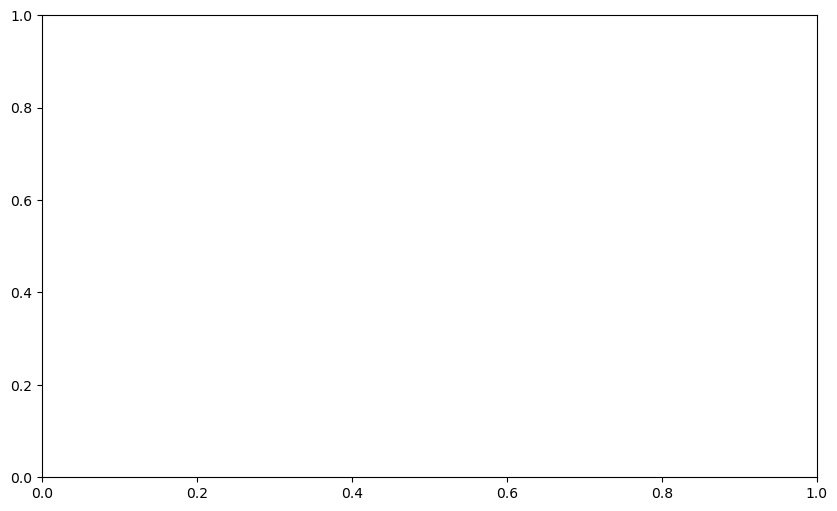

In [132]:
def smooth_curve(x, y, num_points=300):
    # 创建平滑的曲线
    x_smooth = np.linspace(x.min(), x.max(), num_points)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    return x_smooth, y_smooth

# Set into eval mode
model.eval()
likelihood.eval()

random_num = np.random.randint(0, len(X_test_tensor), size=1)[0]
y_true=y_test_tensor[random_num:random_num+1]

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_tensor[random_num:random_num+1]))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()


x_plt_axis = np.arange(len(mean[0]))


print("Num "+str(random_num)+" Chosen for display")
x_plt_axis = np.linspace(0, len(mean) - 1, len(mean))
# 创建图形、
selected_upper_bound=lower[0].numpy().tolist()
selected_lower_bound=upper[0].numpy().tolist()
print(mean.flatten())
print(selected_lower_bound)
print(selected_upper_bound)
plt.figure(figsize=(10, 6))
plt.plot(x_plt_axis, mean.flatten(), label='Predicted', color='blue')
plt.plot(x_plt_axis, y_true.flatten(), label='True', color='red')
plt.fill_between(x_plt_axis, selected_lower_bound, selected_upper_bound, alpha=0.5)
plt.ylim(-0.5, 1.5)
# 添加标题和标签
plt.title('Comparison of Two Smoothed Curves')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)



Num 20 Chosen for display
tensor([1.0061, 1.0013, 0.9249, 0.8561, 0.6715, 0.4052, 0.1974, 0.0731, 0.0173,
        0.0143])
[1.2460695505142212, 1.2406353950500488, 1.184676170349121, 1.2731800079345703, 1.4165751934051514, 1.2809349298477173, 0.7716583609580994, 0.3708448112010956, 0.2554765045642853, 0.2474384605884552]
[0.7661672830581665, 0.7618686556816101, 0.6650382280349731, 0.43895193934440613, -0.0736510157585144, -0.4705829918384552, -0.37688249349594116, -0.224702388048172, -0.22078773379325867, -0.2187725305557251]


ValueError: x and y must have same first dimension, but have shapes (1,) and torch.Size([10])

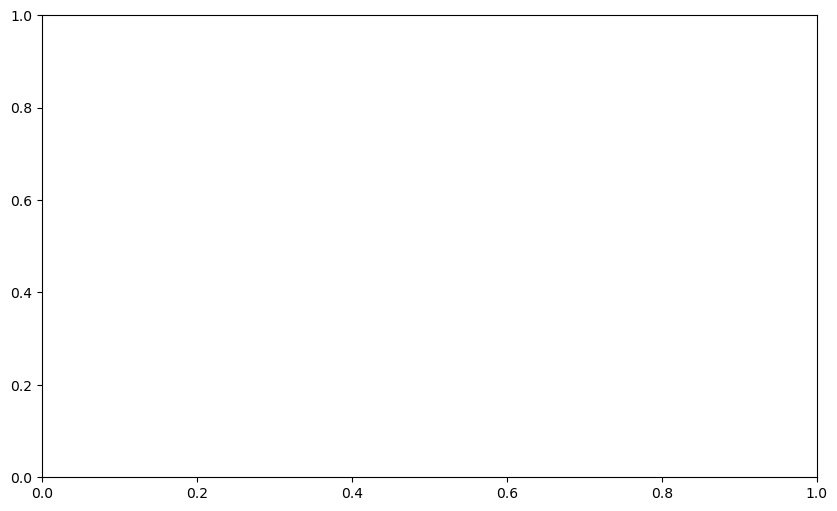